####Disclaimer : Full ML System design and full dataset were excluded to protect company IP

In [ ]:

# This will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer
from sklearn import metrics

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,StackingClassifier

)
from xgboost import XGBClassifier


# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

##**Reading the dataset**

In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Previous_Projects/medical_device_failure.csv")

# copying data to another variable to avoid any changes to original data
data = df.copy()
list(data.columns)

['Device_Fail',
 'Gear_Type',
 'Velocity',
 'Torque(Nm)',
 'Wear_Measure',
 'Sensor_1',
 'Sensor_2']

#### Check for missing values

In [ ]:
data.isna().sum()

Device_Fail     0
Gear_Type       0
Velocity        8
Torque(Nm)      4
Wear_Measure    8
Sensor_1        3
Sensor_2        8
dtype: int64

In [ ]:
data['Device_Fail'].value_counts(normalize = True)

N   0.966
Y   0.034
Name: Device_Fail, dtype: float64

- To prevent data leakage, missing value will be treated after train-test split

##**Data Preparation for model build**

In [ ]:
# Separating features and the target column
X = data.drop('Device_Fail',axis=1)

y = data['Device_Fail'].apply(lambda x : 1 if x=='Y' else 0)

In [ ]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(6000, 6) (2000, 6) (2000, 6)


In [ ]:
print("Number of instances in train set :", X_train.shape[0])
print("Number of instances in validation set =", X_val.shape[0])
print("Number of instances in test set =", X_test.shape[0])

Number of instances in train set : 6000
Number of instances in validation set = 2000
Number of instances in test set = 2000


#### **Treatment of Missing Values**

In [ ]:
from sklearn.impute import SimpleImputer
#select numeric variables of integer and float type
numeric_var = list(X_train.select_dtypes(include=['float','int']).columns)

# Impute numerical columns
numeric_imputer = SimpleImputer(strategy='median') #use mean if data is from a gaussian distribution otherwise you use the median
X_train[numeric_var] = numeric_imputer.fit_transform(X_train[numeric_var])
X_val[numeric_var] = numeric_imputer.transform(X_val[numeric_var])
X_test[numeric_var] = numeric_imputer.transform(X_test[numeric_var])

In [ ]:
# Checking that no column has missing values in train, validation and test sets
print(X_train.isna().sum())
print("~" * 50)
print(X_val.isna().sum())
print("~" * 50)
print(X_test.isna().sum())
print("~" * 50)

Gear_Type       0
Velocity        0
Torque(Nm)      0
Wear_Measure    0
Sensor_1        0
Sensor_2        0
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Gear_Type       0
Velocity        0
Torque(Nm)      0
Wear_Measure    0
Sensor_1        0
Sensor_2        0
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Gear_Type       0
Velocity        0
Torque(Nm)      0
Wear_Measure    0
Sensor_1        0
Sensor_2        0
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


###**Dummy Features**

- As variables are added, the data space becomes increasingly sparse, and classification and prediction models fail because the available data are insufficient to provide a useful model across so many variables.  

- The difficulties posed by adding a variable increase exponentially with the addition of each variable.

- Dimensionality is the number of predictors or input variables in a model, and the “curse” refers to the problems that result from including too many features (predictor variables) in a model.

In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_val.shape, X_test.shape)

(6000, 8) (2000, 8) (2000, 8)


##**Strategy for Algorithm Development**

- Build 3 boosted trees models and stack them together on the train data and observe their performance on test
  
  - `Adaboost`, `GBM` and `XGBoost`

- use `randomizedSearchCV` for model optimization
- Use a user defined function to consolidate all offline performance metrics such precision, recall, F1 measure.

###**Selection of`Anchor` Metric to Evaluate Algorithm performance**


**Loss of Resources Vs Loss of Opportunity tradeoff:**

1. Predicting the device will fail (Y), but in reality, it does not fail (N) - Loss of resources

2. Preidicting the device will not fail (N), but in reality it does fail (Y)  - Loss of opportunity

* Predicting a device will not fail but the device fails

**Strategy to reduce this loss i.e need to reduce False Negatives?**
* maximize `Recall`
**Impact*  Greater `Recall` reduces the likelihood of false negatives.

* **`Recall` is the anchor metric to evaluate model performance**

### **Define and aggregate all performance metrics**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

###**Model Build Iteration 0**

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("GBM", GradientBoostingClassifier(random_state=15)))
models.append(("Adaboost", AdaBoostClassifier(random_state=15)))
models.append(("XGB", XGBClassifier(random_state=15)))

print("\nTraining Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))

print("\nValidation Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance:

GBM: 0.8078817733990148
Adaboost: 0.49261083743842365
XGB: 1.0

Validation Performance:

GBM: 0.6323529411764706
Adaboost: 0.35294117647058826
XGB: 0.5882352941176471


In [ ]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_train = recall_score(y_train, model.predict(X_train))
    scores_val = recall_score(y_val, model.predict(X_val))
    delta1 = scores_train - scores_val
    print("{}: Train_score: {:.2f}, Val_score: {:.2f}, Delta: {:.2f}".format(name, scores_train, scores_val, delta1))


Training and Validation Performance Difference:

GBM: Train_score: 0.81, Val_score: 0.63, Delta: 0.18
Adaboost: Train_score: 0.49, Val_score: 0.35, Delta: 0.14
XGB: Train_score: 1.00, Val_score: 0.59, Delta: 0.41


- observation: `Xgboost` is severely overfitting, `Adaboost` is struggling to understand the underlying patterns in both train and test sets. `GBM` is borderline overfitting.

- To address this, data augmentation technique `undersampling` will be used

#### **Model Build Iteration 1**
####**Data Augmentation - Undersampling of Majority Class**

In [ ]:
rus = RandomUnderSampler(random_state=15)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
print("Undersampling,dimension of train_X: {}".format(X_train_un.shape))
print("Undersampling,dimension of train_y: {}".format(y_train_un.shape))

Undersampling,dimension of train_X: (406, 8)
Undersampling,dimension of train_y: (406,)


In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("GBM", GradientBoostingClassifier(random_state=15)))
models.append(("Adaboost", AdaBoostClassifier(random_state=15)))
models.append(("XGB", XGBClassifier(random_state=15)))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

GBM: 0.9901477832512315
Adaboost: 0.9556650246305419
XGB: 1.0

Validation Performance:

GBM: 0.8823529411764706
Adaboost: 0.8382352941176471
XGB: 0.8529411764705882


In [ ]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores_train = recall_score(y_train_un, model.predict(X_train_un))
    scores_val = recall_score(y_val, model.predict(X_val))
    delta3 = scores_train - scores_val
    print("{}: Train_score: {:.2f}, Val_score: {:.2f}, Delta: {:.2f}".format(name, scores_train, scores_val, delta3))


Training and Validation Performance Difference:

GBM: Train_score: 0.99, Val_score: 0.88, Delta: 0.11
Adaboost: Train_score: 0.96, Val_score: 0.84, Delta: 0.12
XGB: Train_score: 1.00, Val_score: 0.85, Delta: 0.15


Observation : After undersampling - we have been able to address the models inability to generalize on validation set.

- We can optimize the models to see if we can improve performance

- caveat: Hyperparameterization does not gaurantee model improvement, it's a hit or miss

#### **Model Build Iteration 2**

### Optimization : Hyperparameter Tuning

In [ ]:
# Choose the type of classifier.
xodel = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(20,120,10),
              'learning_rate': [1, 0.1, 0.001, 0.01],
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=xodel, param_distributions=parameters, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=15)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best hyperparameter combination are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best hyperparameter combination are {'n_estimators': 50, 'learning_rate': 0.1} with CV score=0.9210975609756098:


In [ ]:
ada_classifier_tuned = AdaBoostClassifier(
    random_state=15,
    n_estimators=50,
    learning_rate=0.1
    )
ada_classifier_tuned.fit(X_train_un, y_train_un)

AdaBoostClassifier(learning_rate=0.1, random_state=15)

In [ ]:
ada_classifier_tuned_model_train_perf = model_performance_classification_sklearn(ada_classifier_tuned, X_train_un, y_train_un)
print("Training performance \n",ada_classifier_tuned_model_train_perf)

Training performance 
    Accuracy  Recall  Precision    F1
0     0.916   0.936      0.900 0.918


In [ ]:
ada_classifier_tuned_model_val_perf = model_performance_classification_sklearn(ada_classifier_tuned, X_val, y_val)
print("Validation performance \n",ada_classifier_tuned_model_val_perf)

Validation performance 
    Accuracy  Recall  Precision    F1
0     0.890   0.868      0.219 0.349


###**Hyperparameter Tuning of Gradient Boosting Classifier using undersampled train set**

In [ ]:
#Creating pipeline
xodel = GradientBoostingClassifier(random_state=15)

#Parameter grid to pass in RandomSearchCV
parameters = {

    "n_estimators": np.arange(10,125,15),
    "learning_rate": [0.01, 0.1, 0.005, 1],
    "subsample":[0.6,0.8,1],
    "max_features":[0.6,0.8,0.9],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=xodel, param_distributions=parameters, n_iter=50, scoring=scorer, cv=5, random_state=15, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.6, 'n_estimators': 70, 'max_features': 0.9, 'learning_rate': 0.1} with CV score=0.9408536585365853:


In [ ]:
gbm_classifier_tuned = GradientBoostingClassifier(
    random_state=15,
    subsample=0.6,
    n_estimators=70,
    max_features=0.9,
    learning_rate=0.1
)
gbm_classifier_tuned.fit(X_train_un, y_train_un)

GradientBoostingClassifier(max_features=0.9, n_estimators=70, random_state=15,
                           subsample=0.6)

In [ ]:
# Checking model's performance on training set
gbm_classifier_train = model_performance_classification_sklearn(
    gbm_classifier_tuned, X_train_un, y_train_un
)
gbm_classifier_train

,Accuracy,Recall,Precision,F1
0,0.973,0.975,0.971,0.973


In [ ]:
# Checking model's performance on training set
gbm_classifier_val = model_performance_classification_sklearn(
    gbm_classifier_tuned, X_val, y_val
)
gbm_classifier_val

,Accuracy,Recall,Precision,F1
0,0.909,0.853,0.253,0.391


###**Hyperparameter Tuning of XGBClassifier using undersampled train set**

In [ ]:
xodel = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
parameters={'n_estimators':np.arange(15,135,15),
            'scale_pos_weight':[1,2,4],
            'learning_rate':[0.01,0.001,0.05,0.1],
            'gamma':[1,3],
            'subsample':[0.5,0.8]
           }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=xodel, param_distributions=parameters, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=15)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'scale_pos_weight': 2, 'n_estimators': 30, 'learning_rate': 0.01, 'gamma': 3} with CV score=1.0:


In [ ]:
xgb_classifier_tuned = XGBClassifier(
    random_state=1,

    subsample=0.5,
    scale_pos_weight=2,
    n_estimators=30,
    learning_rate=0.01,
    gamma=3,
)
xgb_classifier_tuned.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [ ]:
# Checking model's performance on training set
xgb_classifier_train = model_performance_classification_sklearn(xgb_classifier_tuned, X_train_un, y_train_un)
xgb_classifier_train

,Accuracy,Recall,Precision,F1
0,0.500,1.000,0.500,0.667


In [ ]:
# Checking model's performance on val set
xgb_classifier_val = model_performance_classification_sklearn(xgb_classifier_tuned, X_val, y_val)
xgb_classifier_val

,Accuracy,Recall,Precision,F1
0,0.034,1.000,0.034,0.066


###**Stacking Model**

let's build a stacking model with the tuned models - `adaboost`,`XGB`, then use `GBM` to get the final prediction.

In [ ]:
estimators=[('adaboost', AdaBoostClassifier(random_state=15)),('XGB', XGBClassifier(random_state=15))]
final_estimator= GradientBoostingClassifier(random_state=15)

stacking_classifier =StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_classifier.fit(X_train_un,y_train_un)

StackingClassifier(cv=5,
                   estimators=[('adaboost',
                                AdaBoostClassifier(random_state=15)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              impor...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=15, ...))],
                   final_estimator=GradientBoostingClassifier(random_state=15))

###**XGBoost Classifier**

In [ ]:
stacking_classifier_model_train_perf = model_performance_classification_sklearn(stacking_classifier, X_train_un, y_train_un)
print("Training performance \n",stacking_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision    F1
0     0.983   0.990      0.976 0.983


In [ ]:
stacking_classifier_model_test_perf = model_performance_classification_sklearn(stacking_classifier, X_test, y_test)
print("Test performance \n",stacking_classifier_model_test_perf)

Test performance 
    Accuracy  Recall  Precision    F1
0     0.881   0.897      0.209 0.339


### Observation : Per Recall score, undersampling of the train_set improved model performance

#### **Next step: Identify key predictors driving device failure - Feature Importance**

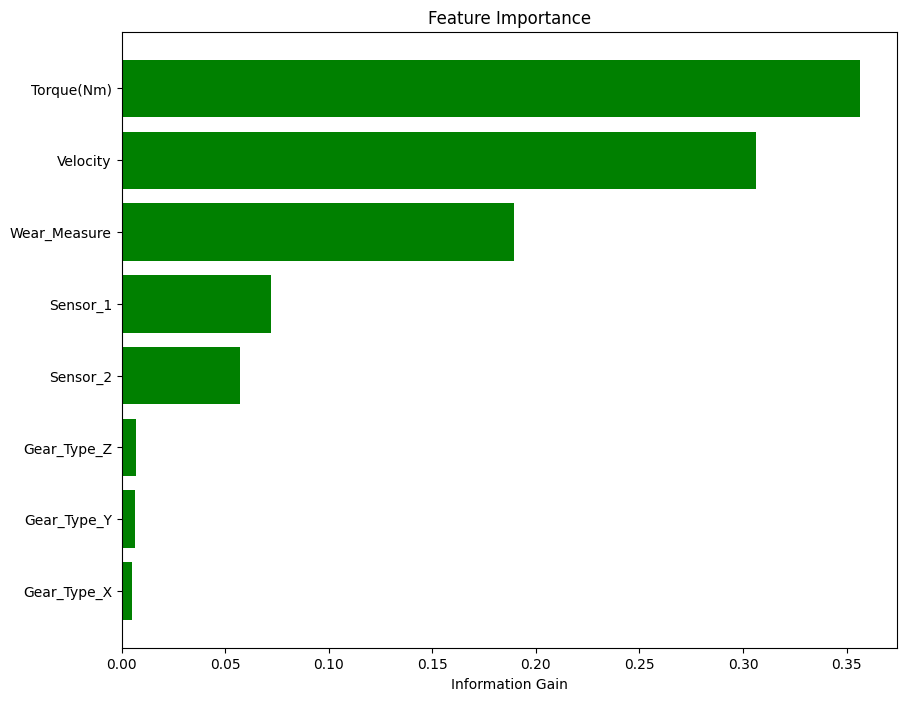

In [ ]:
feature_names = X_train.columns
importances = gbm_classifier_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Information Gain")
plt.show()

####**Observation** `Torque`, `Velocity` and `Wear_Measure` are the key features driving device failure

###**Retrieval of prediction**

In [ ]:
pred = gbm_classifier_tuned.predict(X_test)

y_hats = pd.DataFrame(pred, columns =['y_hats'])
y_hats.sample(10)



,y_hats
1024,0
958,1
1231,0
130,0
1871,1
1609,0
728,0
12,1
1562,0
1543,1
